In [4]:
# Import necessary libraries and modules
import sys
import numpy as np
from scipy.interpolate import interp1d

# change directory
sys.path.append("./python/")
from functions import *

# colossus imports
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
from colossus.halo import concentration

# Plotting imports
import matplotlib.pyplot as plt


## Uncomment if you want to use latex
# import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True


The `funcitons.py` file contains the following functions:
- `sigma_hat` calculates the dimensionless cross-section $\hat{\sigma}$
- `v_rho_n_LS` calculates the 1D central velocity dispersion and central density, at the LS transition, $v_{c,\rm LS}$, and $\rho_{c,\rm LS}$
- `v_rho_10` calculates the 1D central velocity dispersion and central density at the $\gamma=10$ point, $v_{c,10}$, and $\rho_{c,10}$
- `M_c_RI` calculated the core mass at relativistic instability, assuming it occurs at $v_c\simeq c/3$.

## Example 1
Getting the dimensionless cross-section and calculating the instability mass


In [15]:
rho_s= 2e11         # Assuming Msun/kpc^3
V_max= 50           # Assuming km/s
w= 1e4              # Assuming km/s (cross section velocity scale)
sigma_over_m=1      # Assuming cm^2/g

# The code will warn us that sigma_hat is larger than 0.1, possibly exceeding the range of validity of our calculations. 
print(f'sigma_hat={sigma_hat(rho_s,V_max,w,sigma_over_m)}')
print(f'M_c_RI={M_c_RI(rho_s,V_max,w,sigma_over_m)}*M_sun')

some entries with sigma_hat>0.1, proceed with caution
sigma_hat=0.6157104335125778
some entries with sigma_hat>0.1, proceed with caution
M_c_RI=0.6743733227176434*M_sun


## Example 2
Reproducing parts of Figure 8

In [16]:
# set cosmology
cosmo = cosmology.setCosmology('planck18')
h=cosmo.h

# Note that colossus takes in all quantities in units of h. So density is in units h^2 * M_sun/kpc^3, radius in kpc/h,
# and mass in M_sun/h. This means that in units of h, rho will be larger, and r and M will be smaller. To do this, we
# actually have to divide our physical rhos by h^2, so that colossus gets it in units h^2 * M_sun/kpc^3 , and multiply rs and 
# our physical rs and mass by h to get rs in units kpc/h and mass in units M_sun/h.

m200_arr = np.logspace(8,11,20) # in units M_sun
c200_arr = concentration.concentration(m200_arr*h, '200c', 0.0, model = 'diemer19') # m200*h gives colossus mass in M_sun/h

# Mean
p_nfw_arr = np.array([profile_nfw.NFWProfile(M = m*h, c = c, z = 0, mdef = '200c') for m,c in zip(m200_arr,c200_arr)]) # mdef = '200c' is just telling it to use 
rhos_arr = np.array([p.par['rhos']*h**2 for p in p_nfw_arr]) # this rhos is now in units M_sun/kpc^3 as we've removed the h dependence
Vmax_arr = np.array([p.Vmax()[0] for p in p_nfw_arr]) # velocity is always in units km/s

# Low
p_nfw_arr = np.array([profile_nfw.NFWProfile(M = m*h, c = c*10**(-.3), z = 0, mdef = '200c') for m,c in zip(m200_arr,c200_arr)]) # mdef = '200c' is just telling it to use 
rhos_arr_low = np.array([p.par['rhos']*h**2 for p in p_nfw_arr]) # this rhos is now in units M_sun/kpc^3 as we've removed the h dependence
Vmax_arr_low = np.array([p.Vmax()[0] for p in p_nfw_arr]) # velocity is always in units km/s

# Low
p_nfw_arr = np.array([profile_nfw.NFWProfile(M = m*h, c = c*10**(.3), z = 0, mdef = '200c') for m,c in zip(m200_arr,c200_arr)]) # mdef = '200c' is just telling it to use 
rhos_arr_high = np.array([p.par['rhos']*h**2 for p in p_nfw_arr]) # this rhos is now in units M_sun/kpc^3 as we've removed the h dependence
Vmax_arr_high = np.array([p.Vmax()[0] for p in p_nfw_arr]) # velocity is always in units km/s

some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution


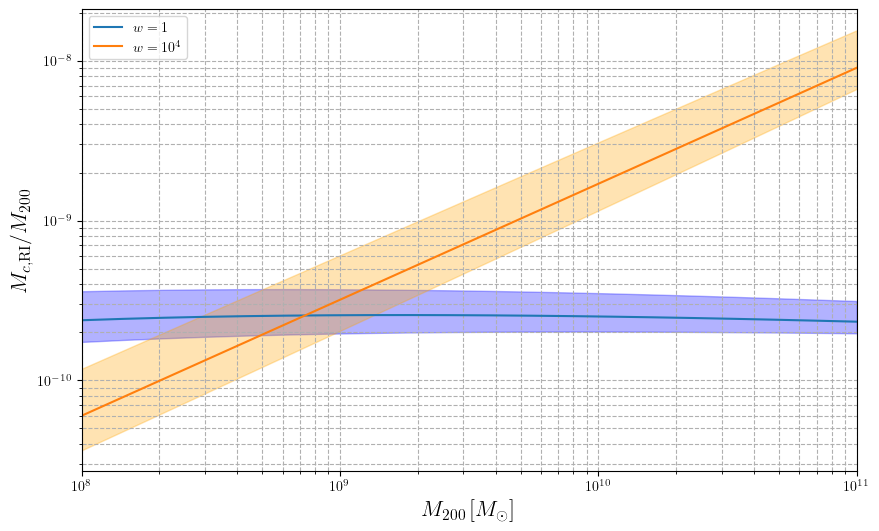

In [17]:
v_scale=20 #km/sec
sigma_over_m_scale=100
sigma_over_1=sigma_over_m_scale/K_5_int(v_scale/1)
sigma_over_1e4=sigma_over_m_scale/K_5_int(v_scale/1e4)


plt.figure(figsize=(10, 6))


# Mean lines
plt.loglog(m200_arr, M_c_RI(rhos_arr, Vmax_arr, 1, sigma_over_1) / m200_arr, label=r'$w=1$')
plt.loglog(m200_arr, M_c_RI(rhos_arr, Vmax_arr, 1e4, sigma_over_1e4) / m200_arr, label=r'$w=10^4$')

# Bands for w=1
plt.fill_between(m200_arr, 
                 M_c_RI(rhos_arr_low, Vmax_arr_low, 1, sigma_over_1) / m200_arr, 
                 M_c_RI(rhos_arr_high, Vmax_arr_high, 1, sigma_over_1) / m200_arr, 
                 color='blue', alpha=0.3)

# Bands for w=1e4
plt.fill_between(m200_arr, 
                 M_c_RI(rhos_arr_low, Vmax_arr_low, 1e4, sigma_over_1e4) / m200_arr, 
                 M_c_RI(rhos_arr_high, Vmax_arr_high, 1e4, sigma_over_1e4) / m200_arr, 
                 color='orange', alpha=0.3)

plt.xlabel(r'$M_{200} \, [M_{\odot}]$', fontsize=16)
plt.ylabel(r'${M_{c,\mathrm{RI}}}/{M_{200}}$', fontsize=16)

plt.legend(loc='upper left')
plt.xlim(1e8, 1e11)
plt.grid(True, which="both", ls="--")

plt.show()
